In [31]:
from dotenv import load_dotenv
load_dotenv()

# %load_ext autoreload
# %autoreload 2

True

In [32]:
from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from typing_extensions import Optional, Annotated, List, Sequence, Dict
import operator

class AgentInputState(MessagesState):
    pass

class AgentState(MessagesState):
    """
    Main state for the full multi-agent research system.
    
    Extends MessagesState with additional fields for research coordination.
    Note: Some fields are duplicated across different state classes for proper
    state management between subgraphs and the main workflow.
    """

    # Input message generated from user conversation history
    input_message: List[Dict[str, str]]
    diagram_type: str
    n_entities: str
    entity_names: list[str] = []
    entity_details: list[str] = []
    n_edges: str
    edges: list[str] = []
    bit_ranges: list[str] = []
    mermaid_code: str

# ===== STRUCTURED OUTPUT SCHEMAS =====
class StartMessageState(BaseModel):
    """Schema for invoking the supervisor agent."""
    diagram_type: str = Field(
        description="Type of diagram provided by the user"
    )
class OCRStateEntities(BaseModel):
    """Schema for invoking the OCR agent."""
    n_entities: str = Field(
        description="Number of entities detected in the image"
    )
    entity_names: List[str] = Field(
        description="Names of entities detected in the image"
    )
    entity_details: List[str] = Field(
        description="Details of entities detected in the image"
    )
class OCRStateEdges(BaseModel):
    """Schema for invoking the OCR agent."""
    n_edges: str = Field(
        description="Number of edges detected in the image"
    )
    edges: List[str] = Field(
        description="Node- Edge Labels - Node triplet of the edges detected in the image"
    )
    bit_ranges: List[str] = Field(
        description="Bit ranges of the headers detected in the image if image is a Packet Diagram"
    )
class CodeAgentState(BaseModel):
    """Schema for invoking the Code agent."""
    mermaid_code: str = Field(
        description="Mermaid code generated by the agent"
    )

In [39]:
from datetime import datetime
from typing_extensions import Literal
import base64
from pathlib import Path

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from prompts.get_diag_prompt import get_diag_prompt
from prompts.extract_entity_prompt import ocr_extract_entity
from prompts.extract_edges_prompt import ocr_extract_edges
from prompts.write_mermaid_prompt import write_mermaid
from prompts.mermaid_examples import mermaid_example

# Initialize model
# model = init_chat_model(model="openai:gpt-4.1", temperature=0.0)
model = init_chat_model(model="openai:gpt-4o-mini", temperature=0.0)


# ===== WORKFLOW NODES =====

def supervisor_node(state: AgentState) -> AgentState:
    """
    Supervisor agent node that reviews research progress and provides feedback.
    """
    # Combine all messages for context
    structured_output_model = model.with_structured_output(StartMessageState)
    response = structured_output_model.invoke([*state["messages"], 
        HumanMessage(content=get_diag_prompt)
    ])
    print("Determined Diagram Type:", response.diagram_type)
    
    return {
        "diagram_type": response.diagram_type
    }

def ocr_agent_entity(state: AgentState) -> AgentState:
    """
    OCR agent node that extracts text from an image.
    """
    structured_output_model = model.with_structured_output(OCRStateEntities)
    response = structured_output_model.invoke([*state["messages"], 
        HumanMessage(content=ocr_extract_entity[state["diagram_type"]])
    ])

    print("Extracted Number of Entity Names:", response.n_entities)
    response.entity_names = [x.strip() for x in response.entity_names if x.strip()]
    print("Extracted Entity Names:", response.entity_names)    
    return {
        "n_entities": response.n_entities,
        "entity_names": response.entity_names,
        "entity_details": response.entity_details
    }

def ocr_agent_edge(state: AgentState) -> AgentState:
    """
    OCR agent node that extracts edges and bit ranges.
    """
    structured_output_model = model.with_structured_output(OCRStateEdges)
    response = structured_output_model.invoke([*state["messages"], 
        HumanMessage(content=ocr_extract_edges[state["diagram_type"]].format(
            n_entities=(state["n_entities"]),
            entity_names=(state["entity_names"]),
        ))
    ])
    response.bit_ranges = [x.strip() for x in response.bit_ranges if x.strip()]
    response.edges = [x.strip() for x in response.edges if x.strip()]
    # print("Extracted Edge Labels:", response.edges)
    # print("Extracted Bit Ranges:", response.bit_ranges)    
    return {
        "edges": response.edges,
        "bit_ranges": response.bit_ranges
    }

def code_agent(state: AgentState) -> AgentState:
    """
    Code generation agent node that creates mermaid code from user request.
    """
    structured_output_model = model.with_structured_output(CodeAgentState)
    response = structured_output_model.invoke([*state["messages"][1:], 
        HumanMessage(content=write_mermaid.format(
            diagram_type=state["diagram_type"],
            examples=mermaid_example[state["diagram_type"]],
            entity_names=state["entity_names"],
            entity_details=state["entity_details"],
            edges=state["edges"],
            bit_ranges=state["bit_ranges"]  
        ))
    ])
    return {
        "mermaid_code": response.mermaid_code
    }


# Build the scoping workflow
teching_graph = StateGraph(AgentState, input_schema=AgentInputState)
teching_graph.add_node("supervisor_node", supervisor_node)
teching_graph.add_node("ocr_agent_entity", ocr_agent_entity)
teching_graph.add_node("ocr_agent_edge", ocr_agent_edge)
teching_graph.add_node("code_agent", code_agent)

teching_graph.add_edge(START, "supervisor_node")
teching_graph.add_edge("supervisor_node", "ocr_agent_entity")
teching_graph.add_edge("ocr_agent_entity", "ocr_agent_edge")
teching_graph.add_edge("ocr_agent_edge", "code_agent")
teching_graph.add_edge("code_agent", END)
teching_graph_workflow = teching_graph.compile()



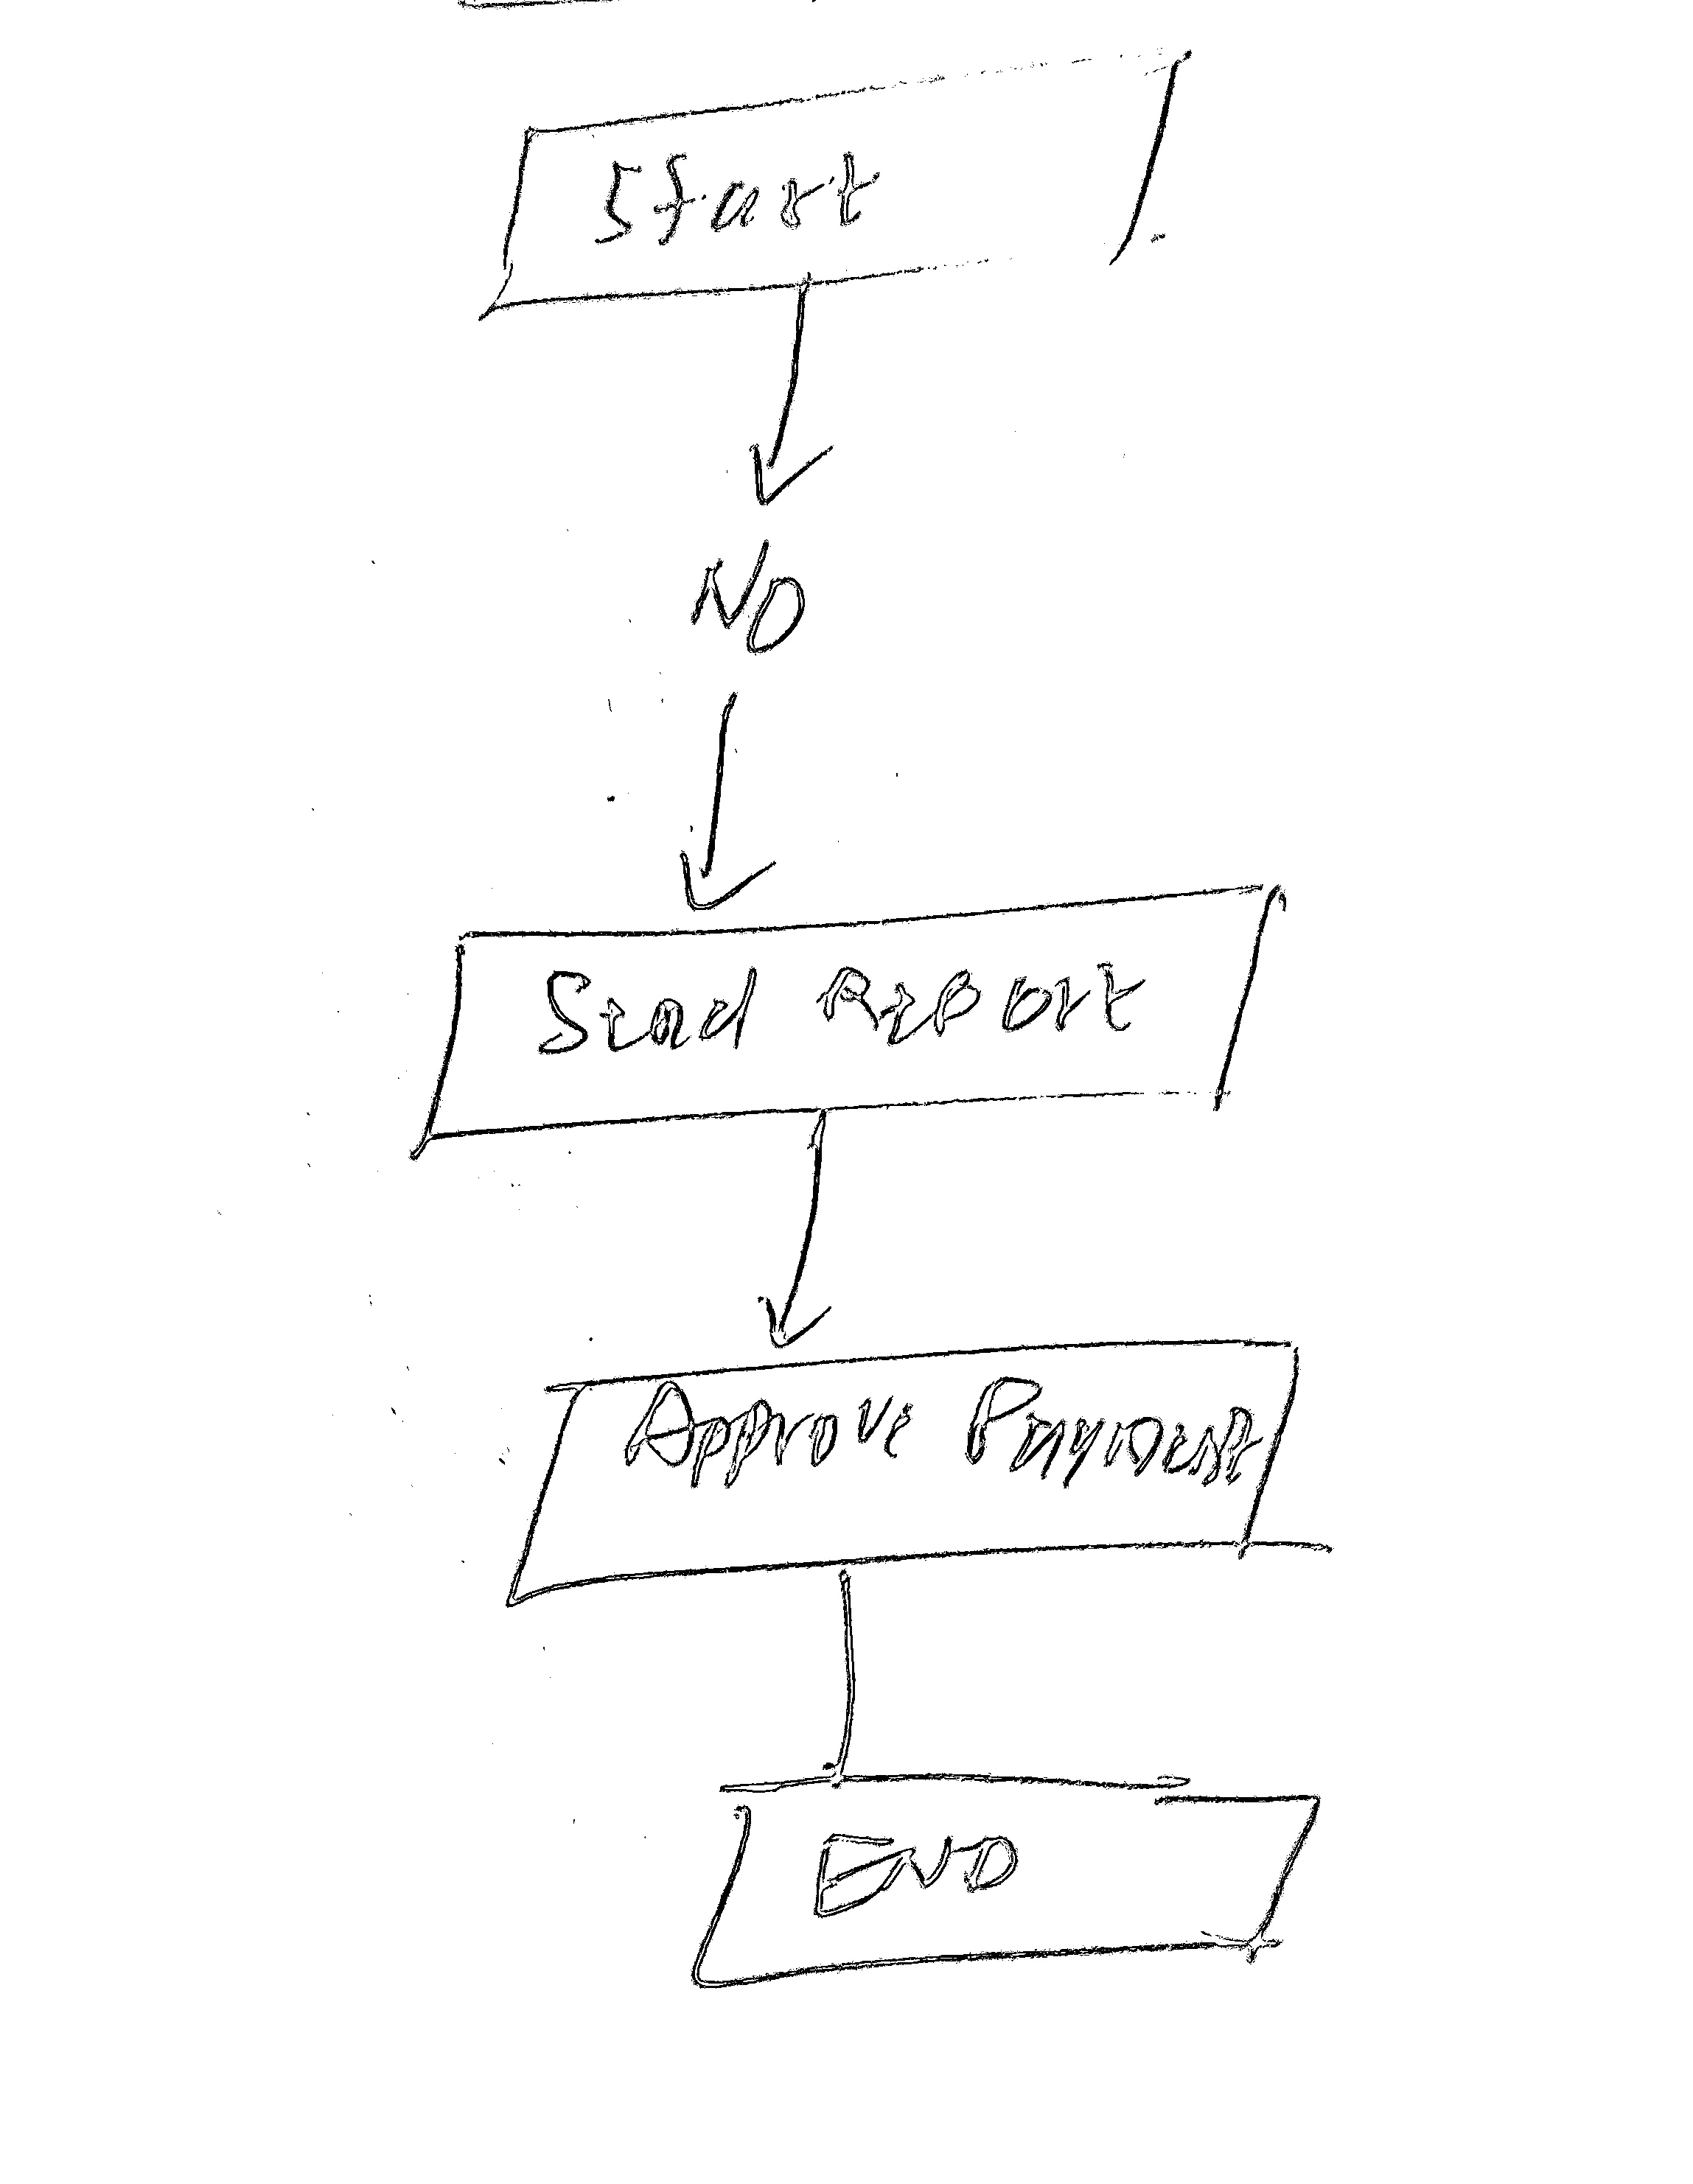

In [40]:
import cv2
import numpy as np
from IPython.display import display, Image as IPImage

# Load image and preprocess it
img_path = Path("pics/41.jpg")
if not img_path.exists():
    raise FileNotFoundError("state.jpg not found in the current working directory")

def preprocess_diagram(input_path, out_path=None, show=True):
    if out_path is None:
        out_path = input_path.with_name(input_path.stem + "_preprocessed" + input_path.suffix)

    img = cv2.imread(str(input_path), cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Unable to read {input_path}")

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Denoise while preserving edges (removes camera/texture noise)
    den = cv2.fastNlMeansDenoising(gray, None, h=10, templateWindowSize=7, searchWindowSize=21)

    # Improve local contrast to make strokes more separable from paper background
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(den)

    # Adaptive threshold to remove low-intensity impressions and handle uneven lighting
    th = cv2.adaptiveThreshold(cl, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, blockSize=15, C=10)

    # Remove small speckles (opening) and optionally strengthen strokes (dilate)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opened = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    processed = cv2.dilate(opened, kernel, iterations=1)

    # Ensure black strokes on white background
    if np.mean(processed) < 127:
        processed = 255 - processed

    cv2.imwrite(str(out_path), th)

    if show:
        display(IPImage(filename=str(out_path)))

    return out_path

# preprocess and overwrite img_path so the later base64 encoding uses the cleaned image
img_path = preprocess_diagram(img_path)

b64 = base64.b64encode(img_path.read_bytes()).decode("ascii")
data_uri = f"data:image/jpeg;base64,{b64}"

In [41]:
first_message = HumanMessage(content=[
    {"type": "text", "text": "Give mermaid code of the given diagram."},
    {"type": "image_url", "image_url": {"url": data_uri}}
])

# result = teching_graph_workflow.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in")]}, config=thread)
result = teching_graph_workflow.invoke({"messages": first_message})
print(result["mermaid_code"])

Determined Diagram Type: Flowchart
Extracted Number of Entity Names: 5
Extracted Entity Names: ['Start', 'NO', 'Send report', 'Approve Purchase', 'End']
```mermaid
flowchart TD
    A["Start"] --> B["NO"]
    B --> C["Send report"]
    C --> D["Approve Purchase"]
    D --> E["End"]
    B --> C
```
